&emsp;

# 上证指数的时序特征

本讲使用 `akshare` 库获取上证指数的历史数据，并使用 `statsmodels` 库进行时间序列分析。主要包括：
- 在线获取上证指数的历史数据，包括：收盘价、开盘价、最高价、最低价、成交量等。
- 计算日收益率、周收益率和年化收益率，并采用 `matplotlib` 库进行可视化。
- 图示收益率的分布特征
  - 收益率的直方图、密度函数图等
  - 收益率的自相关图、偏自相关图等
- 收益率的波动性分析
  - 收益率标准差、方差等

In [79]:
# -*- coding: utf-8 -*-

# 导入必要的库
# pip install akshare
import akshare as ak
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime

# 屏蔽提示信息
import warnings
warnings.filterwarnings("ignore")

# 设置中文字体支持（如已设置可省略）
plt.rcParams['font.sans-serif'] = ['SimHei'] 
plt.rcParams['axes.unicode_minus'] = False    

## 获取数据

In [35]:

# 设置起始时间和结束时间
start_date = '1991-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')  # 设置为当前日期

# 获取上证指数的历史数据
sz_index = ak.stock_zh_index_daily(symbol="sh000001")  # 上证指数代码为 "sh000001"

# 重命名列名以便后续处理
sz_index.rename(columns={'date': 'day', 'close': 'close'}, inplace=True)

# 筛选指定起止时间的数据
sz_index['day'] = pd.to_datetime(sz_index['day'])  # 确保日期列为 datetime 类型
sz_index = sz_index[(sz_index['day'] >= pd.to_datetime(start_date)) & (sz_index['day'] <= pd.to_datetime(end_date))]

print('\n' + '='*10 + ' Head' + '='*10)
print(sz_index.head())  # 显示前几行数据

print('\n' + '='*10 + ' Tail' + '='*10)
print(sz_index.tail())  # 显示后几行数据


========== Head==========
          day    open    high     low   close  volume
9  1991-01-02  127.61  128.84  127.61  128.84    9100
10 1991-01-03  128.84  130.14  128.84  130.14   14100
11 1991-01-04  131.27  131.44  130.14  131.44   42000
12 1991-01-07  131.99  132.06  131.45  132.06   21700
13 1991-01-08  132.62  132.68  132.06  132.68  292600

========== Tail==========
            day      open      high       low     close       volume
8387 2025-04-28  3292.056  3296.932  3279.877  3288.415  41066586300
8388 2025-04-29  3281.445  3294.982  3277.627  3286.655  38896167200
8389 2025-04-30  3284.081  3292.200  3277.550  3279.031  43579433500
8390 2025-05-06  3295.250  3316.448  3286.989  3316.114  47436961700
8391 2025-05-07  3354.974  3356.688  3324.809  3342.665  51115960600


## 收盘价走势图

### 静态图形

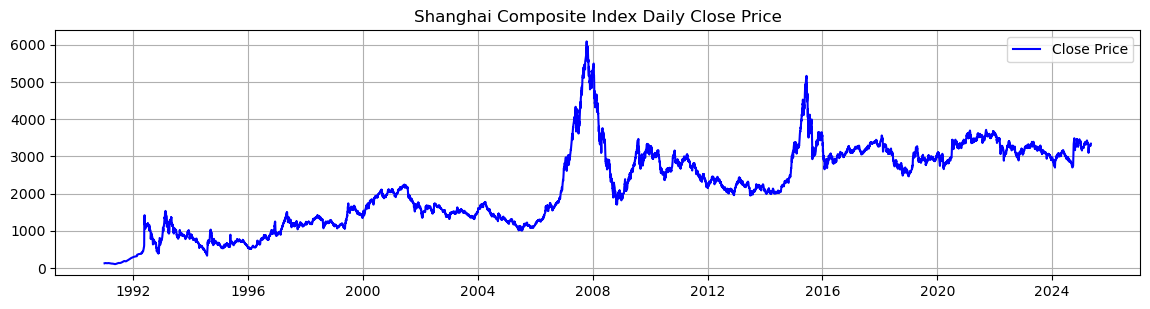

In [36]:
# 绘制收盘价走势图
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(sz_index['day'], sz_index['close'], label='Close Price', color='blue')
plt.title('Shanghai Composite Index Daily Close Price') 
plt.legend()
plt.grid()

### 交互图

接下来，我们使用 `plotly` 扩展包创建一个交互式折线图。顾名思义，这类图形可以在在鼠标悬停时，显示该时点的日期、收益率等信息。要点如下：

1. 数据准备

   - **时间筛选**：通过 `start_date` 和 `end_date` 设置起始时间和结束时间，结合 `pandas.to_datetime()` 函数将日期列转换为标准时间格式，并筛选出指定时间区间内的数据。
   - **数据合并**：使用 `merge()` 函数将包含日收益率的 DataFrame 与主数据表按照日期列进行合并，使得每一日的收盘价配套显示对应的日收益率。

2. 图形绘制

   - **图层添加**：调用 `go.Scatter()` 添加一条收盘价的折线图（`mode='lines'` 表示仅显示折线，不显示节点）。
   - **交互信息**：利用 `hovertemplate` 参数自定义鼠标悬停时显示的内容，包括：日期（格式化为 `年-月-日`）、收盘价（保留两位小数）、日收益率（百分号格式，保留两位小数）等。

3. 图表布局设置

   - 通过 `fig.update_layout()` 设置图表标题、坐标轴标题、交互模式等：
     - `hovermode='x unified'`：使得交互提示在同一垂直线上统一显示
     - `template='plotly_white'`：采用白色背景模板
   - 设置 `margin` 确保图形四周留有足够的空间，避免遮挡

该图表可嵌入网页或 Jupyter Notebook 中动态展示，是教学、报告与展示金融时间序列数据的有力工具。

In [37]:
# 安装必要的库（如未安装）
# !pip install plotly akshare pandas

import pandas as pd
import plotly.graph_objects as go
from datetime import datetime
import akshare as ak

# 设置起始时间和结束时间
start_date = '2005-01-01'
end_date = datetime.now().strftime('%Y-%m-%d')  # 设置为当前日期

# 获取上证指数的历史数据
sz_index = ak.stock_zh_index_daily(symbol="sh000001")  # 上证指数代码为 "sh000001"

# 重命名列名以便后续处理
sz_index.rename(columns={'date': 'day', 'close': 'close'}, inplace=True)

# 将日期列转换为 datetime 类型
sz_index['day'] = pd.to_datetime(sz_index['day'])

# 计算日收益率
sz_index['daily_return'] = sz_index['close'].pct_change()

# 筛选指定时间区间内的数据
filtered_data = sz_index.query(" @start_date <= day <= @end_date ")

# 创建交互式图形对象
fig = go.Figure()

# 添加收盘价的折线图
fig.add_trace(go.Scatter(
    x=filtered_data['day'],
    y=filtered_data['close'],
    mode='lines',  # 只显示线条
    name='收盘价',
    line=dict(color='blue'),
    customdata=filtered_data[['daily_return']].values,
    hovertemplate=(
        '<b>日期：</b> %{x|%Y-%m-%d}<br>'
        '<b>收盘价：</b> %{y:.2f}<br>'
        '<b>日收益率：</b> %{customdata[0]:.2%}<extra></extra>'
    )
))

# 设置图表整体布局
fig.update_layout(
    title='上证指数交互图',
    xaxis_title='日期',
    yaxis_title='收盘价',
    hovermode='x unified',
    template='plotly_white',
    margin=dict(l=60, r=40, t=60, b=50)
)

# 显示图表
fig.show()


### 钉形图

钉形图（`candlestick chart`）是一种常用的金融图表，用于显示某一时间段内的价格波动情况。它通过“钉子”形状的图形来表示开盘价、收盘价、最高价和最低价。钉形图的主要优点在于能够直观地展示价格走势和波动范围，便于分析市场情绪和趋势。

> 有关钉形图的详细解释，参见 [Everything you can do with a time series](https://www.kaggle.com/code/thebrownviking20/everything-you-can-do-with-a-time-series)

钉形图的构建主要包括以下几个步骤：
1. **数据准备**：从 `akshare` 获取上证指数的历史数据，包括开盘价、收盘价、最高价和最低价等。将数据转换为 `pandas` DataFrame 格式，并设置日期为索引。
2. **图形绘制**：使用 `plotly.graph_objects` 中的 `go.Candlestick()` 函数创建钉形图。该函数需要传入开盘价、收盘价、最高价和最低价等数据，并设置相应的颜色（上涨为绿色，下跌为红色）。
3. **图表布局设置**：通过 `fig.update_layout()` 设置图表的标题、坐标轴标签、背景颜色等属性。可以使用 `plotly` 提供的多种模板来美化图表。
4. **交互功能**：钉形图支持鼠标悬停时显示详细信息，包括日期、开盘价、收盘价、最高价和最低价等。可以通过设置 `hovertemplate` 来定制显示内容。

In [74]:
import plotly.graph_objects as go

# 设置起始时间和结束时间
start_date = '2025-01-01'
end_date = '2025-03-30'

# 筛选绘图所需的列
candlestick_data = sz_index.query(" @start_date <= day <= @end_date ")[['day', 'open', 'high', 'low', 'close']]

# 创建钉形图
fig = go.Figure(data=[go.Candlestick(
    x=candlestick_data['day'],       # 日期
    open=candlestick_data['open'],   # 开盘价
    high=candlestick_data['high'],   # 最高价
    low=candlestick_data['low'],     # 最低价
    close=candlestick_data['close'], # 收盘价
    increasing_line_color='green',   # 上涨颜色
    decreasing_line_color='red'      # 下跌颜色
)])

# 设置图表标题和布局
fig.update_layout(
    title='上证指数钉形图',
    template='plotly_white',
    xaxis_rangeslider_visible=False,  # 隐藏范围滑块
    xaxis_tickformat='%Y-%m-%d',  # 设置横轴刻度格式
    xaxis_tickangle=-30,  # 旋转横轴刻度 -30 度
)

# 设置横轴刻度间隔
fig.update_xaxes(
    tickmode='array',
    tickvals=candlestick_data['day'][::5],  # 每隔 5 天显示一个刻度
    ticktext=candlestick_data['day'][::5].dt.strftime('%Y-%m-%d')  # 格式化日期
)

# 显示图表
fig.show()


## 收益率

收益率是金融时间序列分析中的重要指标，通常用于衡量资产价格变动的幅度和速度。我们将计算上证指数的日收益率、周收益率和年化收益率，并进行可视化展示。
- **日收益率**：表示某一天的收盘价与前一天收盘价的比值变化，通常用百分比表示。
- **周收益率**：表示某一周的收盘价与前一周收盘价的比值变化，通常用百分比表示。
- **年化收益率**：表示某一年内的收益率，通常用百分比表示。年化收益率可以通过将日收益率乘以交易天数来计算。

### 日收益率时序图

- **计算方法**：日收益率 = (今日收盘价 - 昨日收盘价) / 昨日收盘价
- **可视化**：
  - 使用 `plt.plot(x, y)` 绘制日收益率的折线图，观察其波动趋势。
  - 使用 `matplotlib` 绘制日收益率的直方图和密度函数图，观察其分布特征。

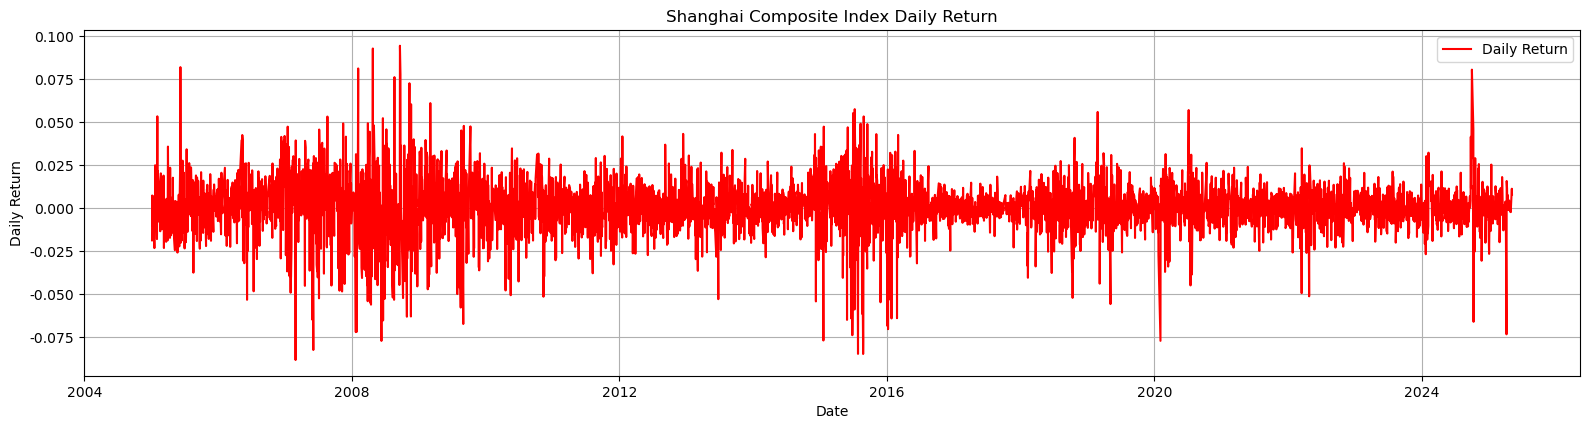

In [38]:
# 计算日收益率
daily_return = sz_index['close'].pct_change()  # 计算日收益率

# 绘制日收益率走势图
#-- 控制绘图的时间范围
#start_plot_date = '1991-01-01'
start_plot_date = '2019-01-01'
end_plot_date   = '2025-05-01'
sz_index_plot = sz_index.query(" @start_date <= day <= @end_date ")

# 绘制日收益率走势图
plt.figure(figsize=(16, 8))  # 调整图形尺寸
plt.subplot(2, 1, 2)
plt.plot(sz_index_plot['day'], 
         sz_index_plot['daily_return'], 
         label='Daily Return', 
         color='red')
plt.title('Shanghai Composite Index Daily Return')
plt.xlabel('Date')
plt.ylabel('Daily Return')
plt.legend()
plt.grid()
plt.tight_layout()  # 调整子图间距


### 箱线图（Boxplot）

箱线图用于展示数据的分布特征，常用于识别数据的集中趋势、离散程度以及可能存在的异常值（outliers）。它特别适合金融数据的分布分析，比如收益率、资产波动率等。

详情参见：[]()

箱线图由以下几个核心部分组成：

* **中位数（Median）**：箱体中间的横线，表示数据的第 50 个百分位数。
* **第一四分位数（Q1）**：箱体下缘，表示数据的第 25 个百分位数。
* **第三四分位数（Q3）**：箱体上缘，表示数据的第 75 个百分位数。
* **四分位距（IQR）**：$IQR = Q3 - Q1$，表示数据的中间 50% 的范围。
* **上胡须**：延伸至 $Q1 - 1.5 \times IQR$ 的位置，用于捕捉非异常值的最大范围。
* **下胡须**：延伸至 $Q3 + 1.5 \times IQR$ 的位置，用于捕捉非异常值的最小范围。
* **异常值（Outliers）**：胡须之外的黑点，表示极端收益波动的观察值。

<img style="width: 550px" src="https://fig-lianxh.oss-cn-shenzhen.aliyuncs.com/box_plots_01.png">

```raw
     Q1-1.5IQR   Q1   median  Q3   Q3+1.5IQR
                  |-----:-----|
  o      |--------|     :     |--------|    o  o
                  |-----:-----|
flier             <----------->            fliers
                       IQR
```

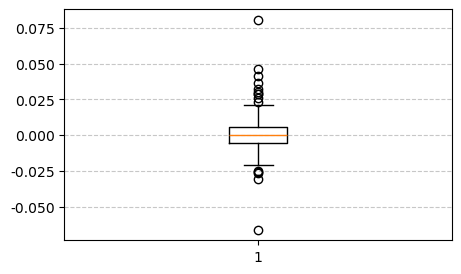

In [55]:
# 筛选 20XX 年的数据
box_year = 2024
df_box_year = sz_index[sz_index['year'] == box_year]['daily_return'].dropna()

plt.figure(figsize=(5, 3))
plt.boxplot(df_box_year)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


### 同时呈现多个箱线图

在实际应用中，可以同时呈现多个箱线图，以便比较不同时间段或不同资产的收益率分布特征。可以使用 `matplotlib` 的 `subplots()` 函数创建多个子图，并在每个子图上绘制箱线图。

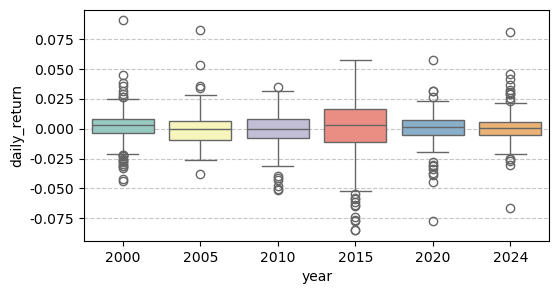

In [77]:
import seaborn as sns
import matplotlib.pyplot as plt

# 提取年份列
sz_index['year'] = sz_index['day'].dt.year

# 筛选指定年份的数据
selected_years = [2000, 2005, 2010, 2015, 2020, 2024]
filtered_data = sz_index[sz_index['year'].isin(selected_years)]

# 绘制多个年度的箱型图
plt.figure(figsize=(6, 3))
sns.boxplot(x='year', y='daily_return', data=filtered_data, palette='Set3')

plt.grid(axis='y', linestyle='--', alpha=0.7)

plt.show()

## 直方图

### 何谓直方图？

直方图（Histogram）是一种用于展示**数值型变量分布情况**的图形工具。其原理是将数据划分为若干**连续、不重叠的区间**（称为“bin”或“箱子”），统计每个区间内数据点的数量，并以矩形的高度表示频数或频率。

设有一组日收益率数据 $\{r_1, r_2, \ldots, r_n\}$，我们将其划分为 $K$ 个等宽的区间，每个区间的宽度为：

$$
h = \frac{\max(r) - \min(r)}{K}
$$

第 $k$ 个区间为 $[a_k, a_{k+1})$，其频数记为 $f_k$，那么对应的矩形高度就是 $f_k$（或标准化后的频率）。绘图过程中，横轴表示收益率区间，纵轴表示该区间的频数或频率。

### 核心代码说明

以下代码用于绘制上证指数的日收益率直方图：

```python
sz_index_plot['daily_return'].dropna().hist(bins=200, figsize=(8, 5))
```

说明如下：

* `daily_return`：表示日收益率列。
* `dropna()`：删除缺失值，避免影响绘图。
* `hist()`：调用 `pandas.DataFrame.hist()` 方法，底层封装了 `matplotlib.pyplot.hist()`。
* `bins=200`：将数据划分为 200 个等宽区间，越大越平滑，但过大可能导致过度拟合。

### 常用参数汇总

| 参数名       | 说明                | 示例                                             |
| --------- | ----------------- | ---------------------------------------------- |
| `bins`    | 设置箱子的数量或箱边界       | `bins=50`，或 `bins=[-0.1, -0.05, 0, 0.05, 0.1]` |
| `density` | 是否标准化为概率密度（面积为 1） | `density=True`                                 |
| `figsize` | 图形大小（宽, 高）        | `figsize=(10, 6)`                              |
| `color`   | 设置柱体颜色            | `color='skyblue'`                              |
| `alpha`   | 设置透明度（0\~1）       | `alpha=0.7`                                    |
| `grid`    | 是否显示网格            | `grid=True`                                    |

### 实用建议

- 若要观察收益率的**分布是否对称**，建议加上垂直参考线，例如均值或中位数。
- 若需与正态分布对比，可叠加核密度曲线（使用 `seaborn.histplot` 或 `sns.kdeplot`）。
- 若数据包含极端值，可调整 `xlim` 参数限制横轴范围，聚焦主要密度区域。

直方图有助于识别收益率分布的偏态、厚尾特征，是金融时间序列分析中不可或缺的工具之一。

<Axes: >

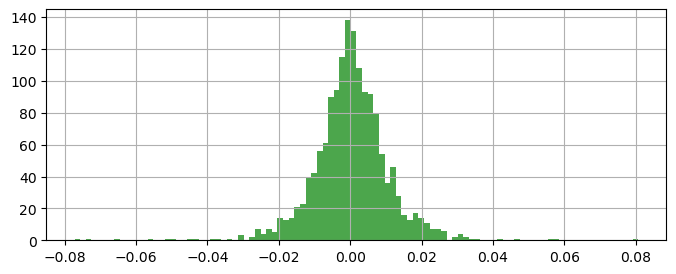

In [ ]:
# 绘制日收益率的基本直方图
sz_index_daily_return = sz_index_plot['daily_return'].dropna()
sz_index_daily_return.hist(bins=100,  # 设置直方图的柱子数量
                           color='green', 
                           alpha=0.7, # 设置透明度
                           figsize=(8, 3))

## 核密度函数

核密度函数 (Kernel Density Estimation, KDE) 是一种用于估计未知概率密度函数的非参数方法，适用于连续型数据且不依赖于事先指定的分布形式。其基本思想是：在密度函数的每一个估计点上，根据样本点到该点的距离，使用核函数分配权重并加权平均，从而构建平滑的密度曲线。

设样本为 $x_1, x_2, \dots, x_n$，其密度函数在任意点 $x$ 上的估计形式为：

$$
\hat{f}_h(x) = \frac{1}{n h} \sum_{i=1}^{n} K\left( \frac{x - x_i}{h} \right)
$$

其中：

- $K(\cdot)$ 是核函数（kernel function），通常是一个对称的概率密度函数；
- $h > 0$ 是带宽参数（bandwidth），控制核函数的缩放程度和平滑水平；
- $\hat{f}_h(x)$ 是点 $x$ 处的密度估计值。

### 核函数

在实际应用中，核函数的选择对估计结果的影响相对较小，而带宽的设置对估计曲线的光滑程度影响较大。

核函数的作用可以理解为：在估计点 $x$ 处，根据样本点 $x_i$ 与 $x$ 之间的距离，赋予不同的权重。距离 $x$ 越近的样本点，其权重越大；距离越远，权重越小。通过对所有样本点的加权平均，得到该点的密度估计。将所有位置的估计值拼接起来，即可得到整体的密度函数曲线。

为了更清楚地理解核函数的加权机制，我们可以对距离进行标准化处理，设：

$$
u_i = \frac{X_i - c}{h}
$$

则以下两式等价：

$$
|u_i| \leq 1 \Longleftrightarrow |X_i - c| \leq h
$$

记 $D_i = |X_i - c|$，表示第 $i$ 个观察值与估计点 $c$ 的距离。核函数的任务就是为每个 $D_i$ 分配权重。

如下图所示，三种典型核函数的权重分配机制具有显著差异：

<img style="width: 600px" src="https://fig-lianxh.oss-cn-shenzhen.aliyuncs.com/Fig-NP-kernel-fn01.png">

- Uniform 核：在 $|u| \leq 1$ 范围内赋予所有观察值相同的权重，超出范围的样本点权重为 0 (相当于弃之不用)。对应的密度估计不具有平滑性，常用于教学演示。
- Triangle 核：采用线性下降的加权方式，距离估计点越近权重越大，边界处权重为 0，估计结果具有一定的连续性。
- Epanechnikov 核：采用抛物线型权重函数，在 $u=0$ 处取得最大值，具有最小均方误差（MSE）性质，估计曲线光滑、效率较高。
- Gaussian 核：采用正态分布函数，所有样本点均有非零权重，平滑程度高，适用于大多数实际应用场景。

### 核函数的性质

**常见核函数及其表达式：**

- **Uniform 核函数** $K(u) = \frac{1}{2} \cdot \mathbf{1}\{\left|u\right| \leq 1\}$ （也称为 Rectangular 核函数）

- **Triangle 核函数** $K(u) = (1 - \left|u\right|) \cdot \mathbf{1}\{\left|u\right| \leq 1\}$
- **Epanechnikov 核函数** $K(u) = \frac{3}{4}(1 - u^2) \cdot \mathbf{1}\{\left|u\right| \leq 1\}$
- **Quartic 核函数** $K(u) = \frac{15}{16}(1 - u^2)^2 \cdot \mathbf{1}\{\left|u\right| \leq 1\}$
- **Triweight 核函数** $K(u) = \frac{35}{32}(1 - u^2)^3 \cdot \mathbf{1}\{\left|u\right| \leq 1\}$
- **Gaussian 核函数** $K(u) = \frac{1}{\sqrt{2\pi}} \exp\left(-\frac{u^2}{2}\right)$
- **Cosinus 核函数** $K(u) = \frac{\pi}{4} \cos\left(\frac{\pi}{2} u\right) \cdot \mathbf{1}\{\left|u\right| \leq 1\}$

<img style="width: 600px" src="https://fig-lianxh.oss-cn-shenzhen.aliyuncs.com/Fig-NP-kernel-fn02.png">

核函数通常需要满足以下数学性质：

1. 非负性：$K(u) \geq 0$
2. 单位积分：$\int_{-\infty}^{\infty} K(u) \, du = 1$
3. 对称性：$K(u) = K(-u)$
4. 有限的二阶矩：$\int u^2 K(u) \, du < \infty$

实际使用中，还有一些细节需要注意。例如，部分文献或软件将 $\mathbf{1}\{|u| \leq 1\}$ 写为 $\mathbf{1}\{|u| < 1\}$。对于连续变量，两者几乎没有区别；但若数据是离散型的（如整数型变量），则可能影响边界值是否被纳入计算。

核密度估计的构造可以理解为：以每一个样本点为中心放置一个缩放后的核函数，然后在每一个估计位置 $x$ 上，取所有样本点的核值加权平均。因此，它是一种基于样本加权“局部贡献”的整体平滑过程。

总结而言：

- 核函数定义了如何根据样本点与估计点之间的距离分配权重；
- 带宽参数决定了每个样本点的影响范围；
- 合理选择核函数和带宽参数是核密度估计中最关键的步骤；
- 核密度估计为我们提供了一种平滑、灵活且无需模型假设的分布估计方法，广泛应用于经济学、金融学、机器学习等领域的探索性数据分析任务中。


<Axes: ylabel='Density'>

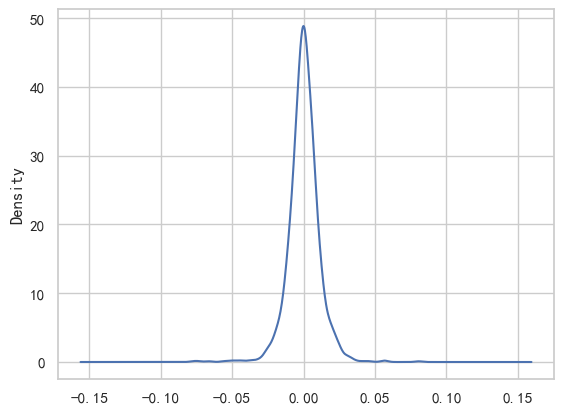

In [97]:
import seaborn as sns

# 日收益率的核密度函数图
sz_index_plot['daily_return'].plot(kind='kde')  #内置函数

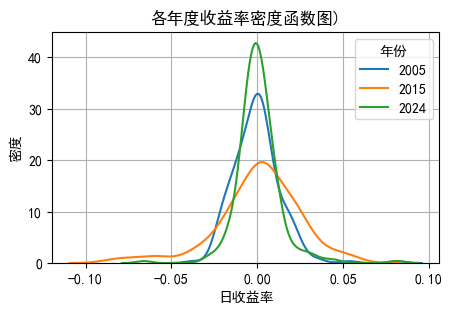

In [81]:
'''提示词
用最简单的命令同时呈现 2005, 2010, 2015, 2020 和 2024 年的收益率密度函数图
'''

import seaborn as sns
import matplotlib.pyplot as plt

# 筛选指定年份的数据
#selected_years = [2005, 2010, 2015, 2020, 2024]
selected_years = [2005, 2015, 2024]
filtered_data = sz_index[sz_index['day'].dt.year.isin(selected_years)]

# 创建图形对象
plt.figure(figsize=(5, 3))

# 绘制每个年份的核密度估计图
for year in selected_years:
    sns.kdeplot(
        data=filtered_data[filtered_data['day'].dt.year == year]['daily_return'].dropna(),
        label=f'{year}'
    )

# 添加标题和图例
plt.title(f'各年度收益率密度函数图)', fontsize=12)
plt.xlabel('日收益率', fontsize=10)
plt.ylabel('密度', fontsize=10)
plt.legend(title='年份')
plt.grid()
plt.show()


## 周收益率和月收益率
- 周收益率：`(本周收盘价 - 上周收盘价) / 上周收盘价`
- 月收益率：`(本月收盘价 - 上月收盘价) / 上月收盘价`

In [59]:
# 计算每周的收益率
sz_index['week'] = sz_index['day'].dt.isocalendar().week  # 提取周数
sz_index['year_week'] = sz_index['day'].dt.year.astype(str) \
                        + '-w' \
                        + sz_index['week'].astype(str).str.zfill(2)  # 组合年份和周数，周数补零

# 计算每周的收益率
weekly_return = sz_index.groupby('year_week')['close'].apply(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0])
weekly_return = weekly_return.reset_index()  # 重置索引
weekly_return.columns = ['Year_Week', 'Weekly_Return']  # 重命名列

# 打印结果
print(weekly_return.sort_values(by='Year_Week').tail(10))  # 按时间顺序显示最后20周的收益率


     Year_Week  Weekly_Return
1729  2025-w09      -0.015455
1730  2025-w10       0.016769
1731  2025-w11       0.015863
1732  2025-w12      -0.017891
1733  2025-w13      -0.005555
1734  2025-w14       0.001877
1735  2025-w15       0.045744
1736  2025-w16       0.004267
1737  2025-w17       0.001102
1738  2025-w18      -0.002854


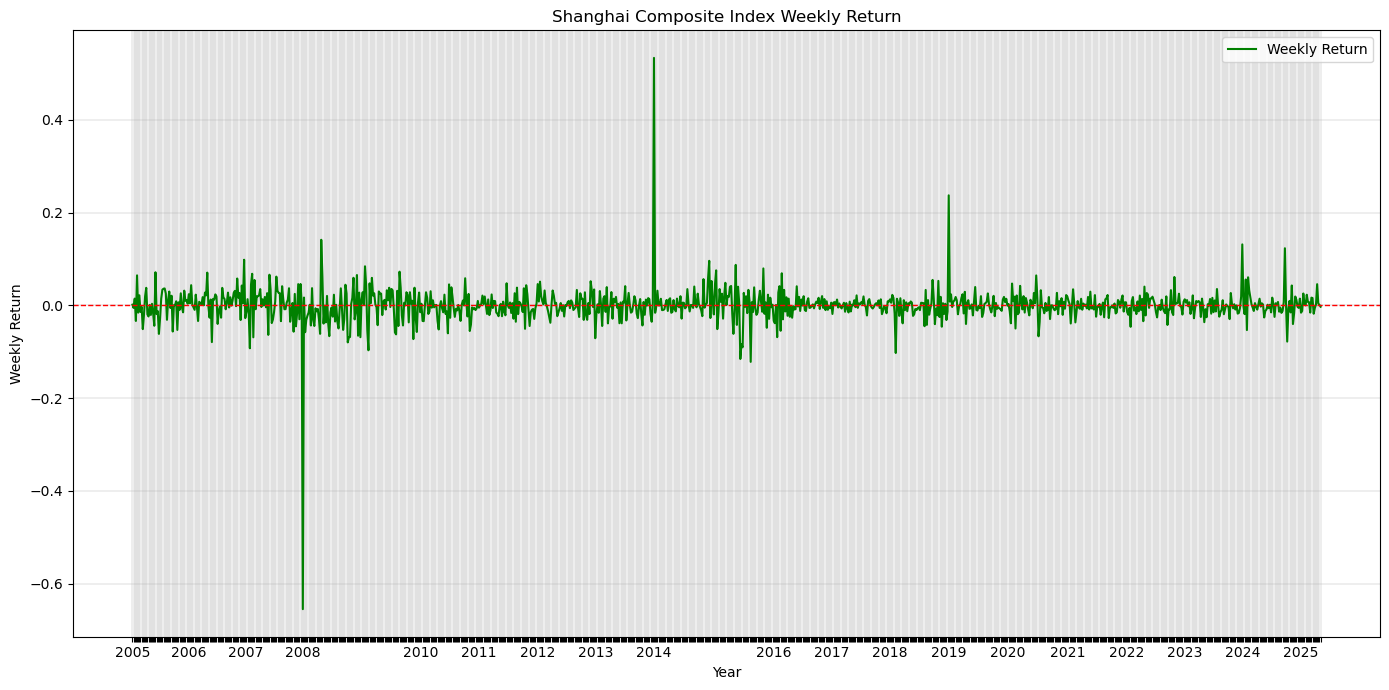

In [60]:
# 设置起始时间和结束时间
start_week = '2005-w01'
end_week = '2028-w16'

# 筛选指定时间范围内的数据
filtered_weekly_return = weekly_return[(weekly_return['Year_Week'] >= start_week) & 
                                       (weekly_return['Year_Week'] <= end_week)]

# 绘制每周收益率走势图
plt.figure(figsize=(14, 7))
plt.plot(filtered_weekly_return['Year_Week'], filtered_weekly_return['Weekly_Return'], label='Weekly Return', color='green')
plt.title('Shanghai Composite Index Weekly Return')
plt.xlabel('Year')
plt.ylabel('Weekly Return')

# 修改 x 轴标签，仅显示年份
year_labels = [label.split('-')[0] if label.endswith('-w01') else '' for label in filtered_weekly_return['Year_Week']]
plt.xticks(ticks=range(len(year_labels)), labels=year_labels, rotation=0)

# 添加 y=0 的水平线
plt.axhline(y=0, color='red', linestyle='--', linewidth=1)

# 设置 grid，仅显示主要的 grid
plt.grid(visible=True, which='major', linestyle='-', linewidth=0.3)

plt.legend()
plt.tight_layout()  # 调整子图间距
plt.show()  # 显示图形


#### 核心代码解读：

- `sz_index['day'].dt.isocalendar().week`：获取日期的周数。具体而言，`dt.isocalendar()` 返回一个 DataFrame，其中包含 ISO 日历的年、周和星期几。我们只需要周数，因此使用 `.week` 来提取它。类似的，可以使用 `.dt.isocalendar().month` 来获取月份；用 `.dt.isocalendar().year` 来获取年份。
    - `sz_index['day'].dt.isocalendar().year`：获取日期的年份。类似地，使用 `.year` 来提取年份。
- `weekly_return = sz_index.groupby('year_week')['close'].apply(lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0])`：对每个周进行分组，计算该周的收益率。具体而言，`groupby('year_week')` 将数据按年和周进行分组，然后使用 `apply()` 函数对每个组应用一个 lambda 函数。这个 lambda 函数计算该组的最后一个收盘价和第一个收盘价之间的收益率。
    - `apply()` 函数的用法：`apply()` 函数可以对 DataFrame 或 Series 的每一行或每一列应用一个函数。它可以用于数据转换、聚合和其他操作。在这里，我们使用 `apply()` 函数来计算每个组的收益率。`apply()` 函数的语法格式为：
        ```python
        DataFrame.apply(func, axis=0, raw=False, result_type=None, args=(), **kwds)
        ```
        - `func`：要应用的函数，可以是 Python 内置函数或自定义函数。
        - `axis`：指定应用函数的轴，0 表示按列应用，1 表示按行应用。默认值为 0。
        - `raw`：如果为 True，则传递原始数据而不是 Series 对象。默认值为 False。
    - `lambda x: (x.iloc[-1] - x.iloc[0]) / x.iloc[0]`：这是一个匿名函数，用于计算每个组的收益率。`x` 是传递给 lambda 函数的参数，表示当前组的数据。`x.iloc[-1]` 表示该组的最后一个收盘价，`x.iloc[0]` 表示该组的第一个收盘价。通过计算这两个值之间的差值并除以第一个收盘价，我们得到了该组的收益率。

In [66]:
# 列出周收益率绝对值大于 0.2 的周
high_weekly_return = weekly_return[weekly_return['Weekly_Return'].abs() > 0.2]

# 按收益率排序
high_weekly_return = high_weekly_return.sort_values(by='Weekly_Return', ascending=False)  
print('\n' + '---'*5 + 'high weekly return' + '---'*5)
print(high_weekly_return)  # 打印结果

# 按时间排序
high_weekly_return = high_weekly_return.sort_values(by='Year_Week')  # 按时间排序
print('\n' + '---'*5 + 'sorted by Year_Week' + '---'*5)
print(high_weekly_return)  # 打印结果


---------------high weekly return---------------
     Year_Week  Weekly_Return
72    1992-w21       1.343377
0     1991-w01       1.272198
259   1996-w01       0.704906
99    1992-w48       0.553815
1159  2014-w01       0.533468
186   1994-w31       0.532717
226   1995-w20       0.470363
118   1993-w14       0.311382
309   1997-w01       0.298735
1415  2019-w01       0.237227
507   2001-w01      -0.217497
854   2008-w01      -0.654681

---------------sorted by Year_Week---------------
     Year_Week  Weekly_Return
0     1991-w01       1.272198
72    1992-w21       1.343377
99    1992-w48       0.553815
118   1993-w14       0.311382
186   1994-w31       0.532717
226   1995-w20       0.470363
259   1996-w01       0.704906
309   1997-w01       0.298735
507   2001-w01      -0.217497
854   2008-w01      -0.654681
1159  2014-w01       0.533468
1415  2019-w01       0.237227


## 年化收益率和标准差

In [57]:

# 各个年度的收益率和标准差
sz_index['year'] = sz_index['day'].dt.year  # 提取年份
annual_stats = sz_index.groupby('year').agg({'daily_return': ['mean', 'std']}).reset_index()

# 重命名列名
annual_stats.columns = ['Year', 'Mean Daily Return', 'Std Daily Return']
# 将收益率和标准差转换为百分比，并计算年化收益率和年化标准差
annual_stats['Mean Daily Return'] = annual_stats['Mean Daily Return'] * 100  # 转换为百分比
annual_stats['Std Daily Return'] = annual_stats['Std Daily Return'] * 100  # 转换为百分比
annual_stats['Annualized Return'] = annual_stats['Mean Daily Return'] * 252 / 100  # 年化收益率
annual_stats['Annualized Std'] = annual_stats['Std Daily Return'] * (252 ** 0.5) / 100  # 年化标准差
# 打印单数年份的收益率和标准差，小数点后保留三位，四列在同一行呈现
print(annual_stats[annual_stats['Year'] % 2 == 1][['Year', 'Mean Daily Return', 'Std Daily Return', 'Annualized Return', 'Annualized Std']].round(3).to_string(index=False))


 Year  Mean Daily Return  Std Daily Return  Annualized Return  Annualized Std
 1991              0.326             0.662              0.821           0.105
 1993              0.096             3.781              0.243           0.600
 1995             -0.016             3.103             -0.041           0.493
 1997              0.133             2.194              0.335           0.348
 1999              0.089             1.773              0.224           0.281
 2001             -0.087             1.387             -0.218           0.220
 2003              0.047             1.143              0.118           0.181
 2005             -0.027             1.378             -0.067           0.219
 2007              0.305             2.216              0.768           0.352
 2009              0.259             1.901              0.653           0.302
 2011             -0.093             1.156             -0.235           0.183
 2013             -0.023             1.159             -0.057   

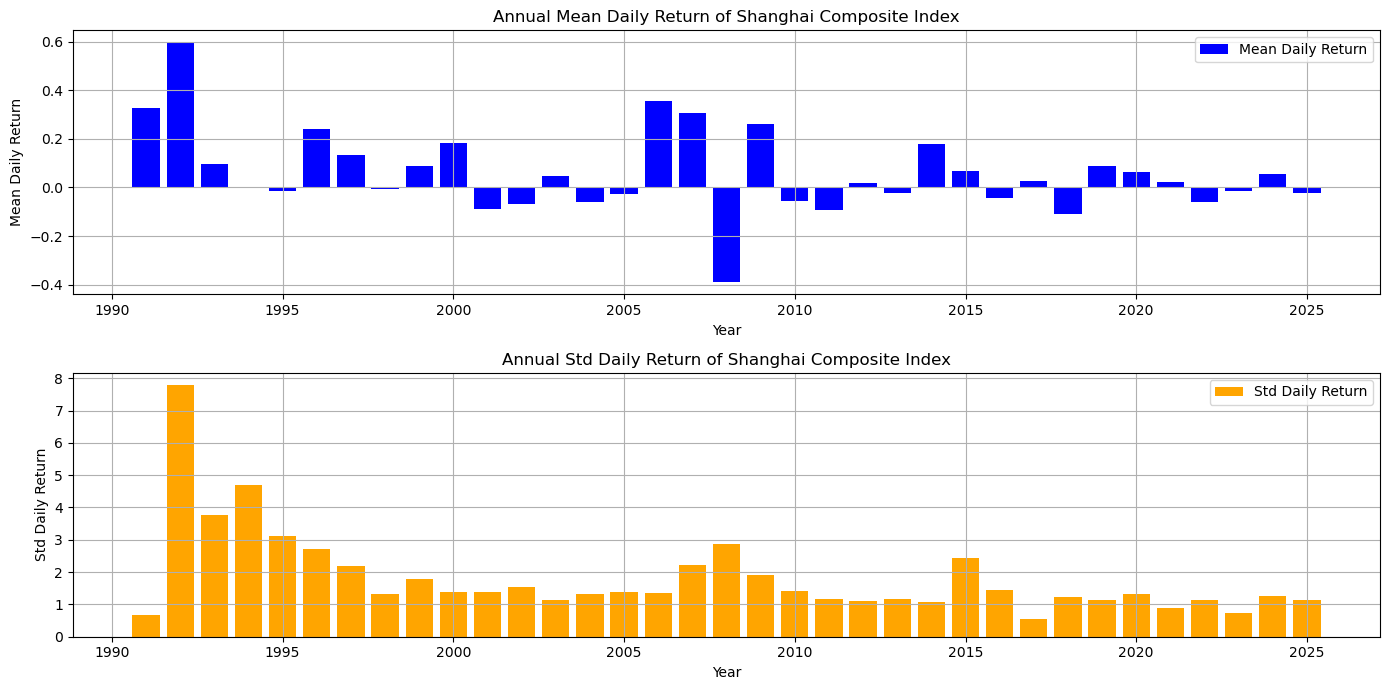

In [ ]:
# 图示各个年度收益率和标准差
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.bar(annual_stats['Year'], annual_stats['Mean Daily Return'], color='blue', label='Mean Daily Return')
plt.title('Annual Mean Daily Return of Shanghai Composite Index')
plt.xlabel('Year')
plt.ylabel('Mean Daily Return')
plt.legend()
plt.grid()
plt.subplot(2, 1, 2)
plt.bar(annual_stats['Year'], annual_stats['Std Daily Return'], color='orange', label='Std Daily Return')
plt.title('Annual Std Daily Return of Shanghai Composite Index')
plt.xlabel('Year')
plt.ylabel('Std Daily Return')
plt.legend()
plt.grid()
plt.tight_layout()  # 调整子图间距
plt.show()  # 显示图形

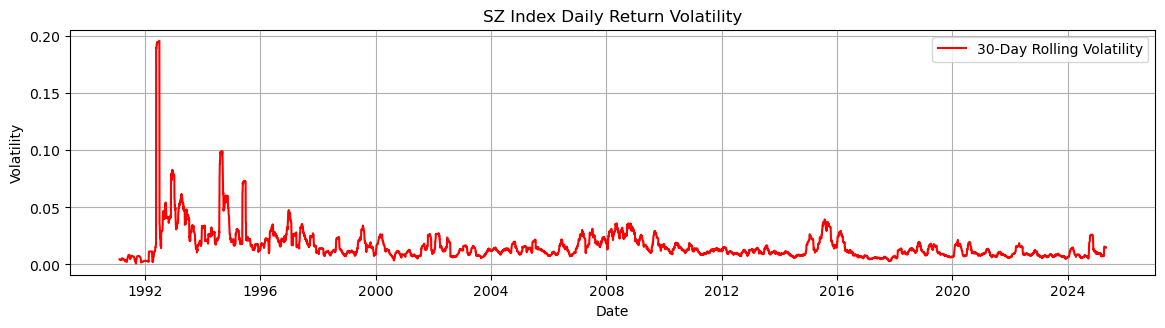

In [17]:

# 图示波动率
plt.figure(figsize=(14, 7))
plt.subplot(2, 1, 1)
plt.plot(sz_index['day'], 
         sz_index['daily_return'].rolling(window=30).std(), 
         label='30-Day Rolling Volatility', 
         color='red')
plt.title('SZ Index Daily Return Volatility')
plt.xlabel('Date')
plt.ylabel('Volatility')
plt.legend()
plt.grid()
plt.show()  # 显示图形


<Figure size 400x300 with 0 Axes>

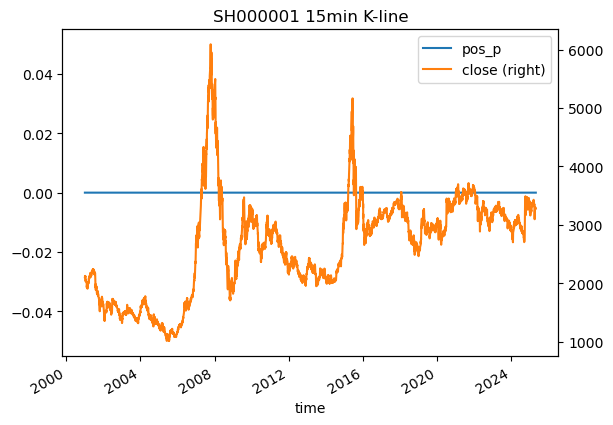

In [10]:

# 将日期列转换为 datetime 类型
sz_index['day'] = pd.to_datetime(sz_index['day'])

# 将收盘价列转换为浮点数类型
sz_index['close'] = sz_index['close'].astype('float')

# 创建一个示例 DataFrame，用于合并
data = pd.DataFrame({'time': sz_index['day'], 'pos_p': [0] * len(sz_index)})

# 合并两个 DataFrame，基于时间列进行内连接
data = data.merge(sz_index, left_on='time', right_on='day', how='inner')

# 绘制图表
plt.figure(figsize=(4, 3))  # 设置图表大小
data.index = data['time']  # 将时间列设置为索引
data[['pos_p', 'close']].plot(secondary_y=['close'])  # 绘制双 Y 轴图表
plt.title('SH000001 15min K-line')  # 设置图表标题
plt.show()  # 显示图表